<a href="https://colab.research.google.com/github/ajasja/INSRTR/blob/main/INSRTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSRTR -- Designed allosteric protein logic

Regulation of the activity of proteins enables control of complex cellular processes. This platform enables the construction of ON/OFF protein switches, their regulation by small molecules, and Boolean logic functions with a rapid response in mammalian cells. 

The notebook is used to predict optimal regulatory insertion sites. Structures containing regulatory coiled-coils are also predicted using AlphaFold2.

For more information please see Plaper, Merljak, Fink et all: https://www.biorxiv.org/content/10.1101/2022.06.03.494683v1
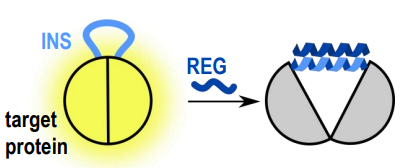

In [ ]:
#@title Setup and import packages
#@markdown This step takes ~3 minutes. 
!pip install py3Dmol biopython mdtraj > /dev/null
import py3Dmol
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets.widgets import IntSlider, Layout, FloatSlider, Checkbox, ToggleButtons, HBox, VBox, Button, Text
from pathlib import Path

! pip install --upgrade git+https://github.com/ajasja/INSRTR.git

import insrtr

In [ ]:
#@title Upload pdb 
#@markdown Click the "Choose Files" button that will appear bellow after running this cell.
from google.colab import files
from pathlib import Path
up_files = files.upload()
up_file_name = list(up_files.keys())[0] # get the first file
up_file_stem = Path(up_file_name).stem

with open(up_file_name, 'r') as file:
    model = file.read()

from Bio.PDB import PDBParser, PPBuilder, PDBIO

#get sequence from PDB
ppb=PPBuilder()
structure = PDBParser(PERMISSIVE=1, QUIET=True).get_structure(up_file_name, up_file_name)
seq = ":".join([str(pp.get_sequence()) for pp in ppb.build_peptides(structure)]) # should in theory support multichain structures. 

In [ ]:
#@title Run the editor/prediction
#@markdown executing the cell will create an interactive GUI where the best insertion sites can be predicted and visualised.
from pathlib import Path
import insrtr.models as clf


model_file_path = Path(clf.__path__[0]).joinpath(insrtr.MODEL_NAME)

p = py3Dmol.view(width=800, height=480)

p.addModels(model, "pdb")

p.setStyle({'cartoon': {'color':'spectrum'}})

p.zoomTo()
p.show()

# a flag that indicates whether the predictive model was applied
predictions_made = False
best_three_resi_index1 = []
df_all = []
df_predictions = []
descriptions = []

def on_position_change(change):
    p.addStyle({'sphere':{'hidden':True}});
    p.addStyle({'resi': position.value, 'atom': 'CA'}, {'sphere':{'color': 'green', 'scale':2, 'hidden':False}});
    if predictions_made:
        for best_pos in best_three_resi_index1:
            if position.value != best_pos: # Sadly does not want to show two spheres at the same time...
                p.addStyle({'resi': best_pos, 'atom': 'CA'}, {'sphere':{'color': 'green', 'opacity':0.5, 'scale':1.5, 'hidden':False}});
    p.update()

def on_find_pos_click(change):
    global df_all, df_predictions, descriptions, best_three_resi_index1, predictions_made
    active_sites_list = find_features()
    if active_sites_list:
      print("Predicting best insertion sites...")
      df_predictions, df_all = insrtr.predict_positions(df_all, model_file_path, exclude_resi_index1=active_sites_list)

      best_three_resi_index1 = list(df_predictions.resi_index0+1)
      predictions_made = True
      
      #Recolor by prediction probability
      recolor_by_prediction_probability()
      
      position.value = best_three_resi_index1[0]
      print("Top 3 suggested insertion sites are:")
      print(best_three_resi_index1)

def find_features():
    global df_all, descriptions
    active_sites_list = []
    print("Analyzing features...")
    if active_site.value.strip()=='':
        print('Please add active site residues!')
        return
    try:
        active_sites_list = [int(site) for site in str(active_site.value).split(',')]
    except:
       print('Active site residues are not correctly formatted.')
       print('Please input a comma separeted list, for example: 1,2,3')
       return  
    include_str = ''
    if include_L.value:
      include_str = include_str + 'L'
      print('Include loops')
    if include_H.value:
      include_str = include_str + 'H'
      print('Include helices')
    if include_E.value:
      include_str = include_str + 'E'
      print('Include strands')     

    if include_str=='':
        print('At least one type of secondary structure has to be included!')
        return 
    
    analyzer = insrtr.LoopAnalyzer(up_file_name, struct_name=name_input.value, active_res_index1=active_sites_list, include_dssp=include_str)
    df_all = analyzer.analyze_structure()
    descriptions = analyzer.feature_descriptions_table
    print("Done analyzing features!")
    
    return active_sites_list

def recolor_by_prediction_probability():
    # Under development for coloring by prediction
    df_all_indexed = df_all.set_index('resi_index0')
    for atom in structure.get_atoms():
        #print(dir(atom.parent))
        #print(atom.bfactor,atom.parent.id[1])
        resi_index0 = atom.parent.id[1]-1
        if resi_index0 in df_all_indexed.index:
          atom.set_bfactor(df_all_indexed.loc[resi_index0].probability_Y)
        else:
          atom.set_bfactor(0.5) # TODO: we need another color for predictions that were not calculated

    io = PDBIO()
    io.set_structure(structure)
    io.save(up_file_name)

    with open(up_file_name, 'r') as file:
        model = file.read()
    
    p.removeAllModels()

    p.addModels(model, "pdb")

    p.setStyle({'cartoon':{'colorscheme':{'prop': 'b', 'gradient':'linear', 'min':0,'max':1, 'colors': ["red","gray","gray","gray","green"]}}});



def on_save_features_click(change):
    base_name = Path(up_file_name).with_suffix('')
    feat_name = base_name.with_suffix('.features.xlsx')
    desc_name = base_name.with_suffix('.descriptions.xlsx')
    active_sites_list = 0
    # Avoid recalculating the features if they were already calculated for the best position prediction; also check if active sites have been inserted
    if not predictions_made:
        active_sites_list = find_features()  
    else:
        active_sites_list = 1

    if active_sites_list:
      df_all.to_excel(feat_name)
      descriptions.to_excel(desc_name)
      from google.colab import files
      files.download(feat_name)
      files.download(desc_name)

    print("Features saved!")


wide_layout = dict(description_width="initial")
position=IntSlider(min=1, max=len(seq), value=1, step=1, continuous_update=True, 
                   description='insert position', 
                   tooltip='Position of CC insertion', style=wide_layout)
position.observe(on_position_change, names='value')
on_position_change(position)

find_pos=Button(description='Predict best sites', tooltip='Find best insertion sites')
find_pos.on_click(on_find_pos_click)
find_pos.style.button_color = 'lightgreen'

save_features=Button(description='Save features', tooltip='Save the features used for predicton')
save_features.on_click(on_save_features_click)

active_site = widgets.Text(
    description='Functional site residues:',
    tooltip='List of functional (active or binding) site residues. Numbering is form 1 to N.',   
    style=wide_layout 
)

name_input = widgets.Text(
    value=up_file_stem,
    description='Name of structure:',
    style = wide_layout
)
CC1 = widgets.Dropdown(
    options=insrtr.COILED_COILS.keys(),
    value='P7',
    description='Inserted CC:',
    tooltip='CC that will be inserted into the protein'
)

link1 = widgets.Dropdown(
    options=['GSSGS', 'SPGGS', 'SGSSGS'],
    value='GSSGS',
    description='Linker 1:',
    tooltip='Select N-terminal linker for CC'
)

link2 = widgets.Dropdown(
    options=['GSGGS', 'GGSGGG'],
    value='GSGGS',
    description='Linker 2:',
    tooltip='Select C-terminal linker for CC'
)

CC2 = widgets.Dropdown(
    options=insrtr.COILED_COILS.keys(),
    value='N8',
    description='Regulatory CC:',
    tooltip='CC that is added as ligand',
    style=wide_layout 
)

include_L = widgets.Checkbox(
    value=True,
    description='Include loops'
)
include_H = widgets.Checkbox(
    value=False,
    description='Include helices'
)
include_E = widgets.Checkbox(
    value=False,
    description='Include strands'
)

include_label = widgets.Label("Secondary structure to consider for prediction:", style=wide_layout)

display(
    HBox([widgets.Label("Residues are counted from 1 to N")]),
    HBox([active_site, name_input]),
    HBox([include_label, VBox([include_L, include_H, include_E])]),
    HBox([position, find_pos, save_features]),
    HBox([CC1, link1, link2]),
    HBox([CC2])
)


In [ ]:
#@title Display amino acid sequence

target_seq = insrtr.insert_sequence(seq, position.value, link1.value+insrtr.COILED_COILS[CC1.value]+link2.value)
target_seq_ligand = target_seq+':'+insrtr.COILED_COILS[CC2.value]
print("Target sequence: ")
print(target_seq)
print("Target sequence with ligand: ")
print(target_seq_ligand)

In [ ]:
#Create query file
with open(f"INSRTR_target.csv", "w") as text_file:
    text_file.write(f"id,sequence\ntarget_seq,{target_seq}\ntarget_seq_ligand,{target_seq_ligand}")
queries_path="INSRTR_target.csv"

#@markdown ### ColabFold Settings
#@markdown ###### Inspired from ColabFold, made by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger))

msa_mode = "MMseqs2 (UniRef+Environmental)" #@param ["MMseqs2 (UniRef+Environmental)", "MMseqs2 (UniRef only)","single_sequence","custom"]
pair_mode = "unpaired+paired" #@param ["unpaired+paired","paired","unpaired"] {type:"string"}
num_models = 5 #@param [1,2,3,4,5] {type:"raw"}
num_recycles = 3 #@param [1,3,6,12,24,48] {type:"raw"}
use_amber = False #@param {type:"boolean"}
use_templates = False #@param {type:"boolean"}
model_type = "auto" #param ["auto", "AlphaFold2-ptm", "AlphaFold2-multimer-v1", "AlphaFold2-multimer-v2"]
#markdown - "auto" = protein structure prediction using "AlphaFold2-ptm" and complex prediction "AlphaFold-multimer-v2". For complexes "AlphaFold-multimer-v[1,2]" and "AlphaFold-ptm" can be used.

##Save to google drive
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive

if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive!")

In [ ]:
#@title Install dependencies
%%bash -s $use_amber $use_templates

set -e

USE_AMBER=$1
USE_TEMPLATES=$2

if [ ! -f COLABFOLD_READY ]; then
  # install dependencies
  # We have to use "--no-warn-conflicts" because colab already has a lot preinstalled with requirements different to ours
  pip install -q --no-warn-conflicts "colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold"
  # high risk high gain
  pip install -q "jax[cuda11_cudnn805]>=0.3.8,<0.4" -f https://storage.googleapis.com/jax-releases/jax_releases.html
  touch COLABFOLD_READY
fi

# setup conda
if [ ${USE_AMBER} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f CONDA_READY ]; then
    wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
    rm Miniconda3-latest-Linux-x86_64.sh
    touch CONDA_READY
  fi
fi
# setup template search
if [ ${USE_TEMPLATES} == "True" ] && [ ! -f HH_READY ]; then
  conda install -y -q -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python=3.7 2>&1 1>/dev/null
  touch HH_READY
fi
# setup openmm for amber refinement
if [ ${USE_AMBER} == "True" ] && [ ! -f AMBER_READY ]; then
  conda install -y -q -c conda-forge openmm=7.5.1 python=3.7 pdbfixer 2>&1 1>/dev/null
  touch AMBER_READY
fi

In [ ]:
#@title Run Structure Prediction
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt


# For some reason we need that to get pdbfixer to import
if use_amber and '/usr/local/lib/python3.7/site-packages/' not in sys.path:
    sys.path.insert(0, '/usr/local/lib/python3.7/site-packages/')

def prediction_callback(unrelaxed_protein, length, prediction_result, input_features, type):
  fig = plot_protein(unrelaxed_protein, Ls=length, dpi=150)
  plt.show()
  plt.close()

result_dir="."
if 'logging_setup' not in globals():
    setup_logging(Path(".").joinpath("log.txt"))
    logging_setup = True

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)
download_alphafold_params(model_type, Path("."))
run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=None,
    use_amber=use_amber,
    msa_mode=msa_mode,    
    model_type=model_type,
    num_models=num_models,
    num_recycles=num_recycles,
    model_order=[1, 2, 3, 4, 5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    recompile_padding=1.0,
    rank_by="auto",
    pair_mode=pair_mode,
    stop_at_score=float(100),
    dpi=200
    #prediction_callback=prediction_callback,
)

In [ ]:
#@title Save to google drive or download results
!zip -FSr "INSRTR_result.zip" *".pdb" config.json

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': "INSRTR_result.zip"})
  uploaded.SetContentFile("INSRTR_result.zip")
  uploaded.Upload()
  print(f"Uploaded INSRTR_result.zip to Google Drive with ID {uploaded.get('id')}")

if not save_to_google_drive:
    files.download("INSRTR_result.zip")
#else:
    def download_click(change):
        files.download("INSRTR_result.zip")

    download_zip=Button(description='Download results')
    download_zip.on_click(download_click)
    display(HBox([download_zip]))

In [ ]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend

model = "target_seq" #@param ["target_seq", "target_seq_ligand"]
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

if use_amber:
  pdb_filename = f"{model}_relaxed_rank_{rank_num}_model_*.pdb"
else:
  pdb_filename = f"{model}_unrelaxed_rank_{rank_num}_model_*.pdb"

pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num,show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show() 